In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./consumer_complaints.csv", encoding="latin-1")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9960\3627187269.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./consumer_complaints.csv", encoding="latin-1")


In [3]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [4]:
df.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id'],
      dtype='object')

### Feature selection


In [5]:
df = df[["product", "consumer_complaint_narrative"]]
df.shape

(555957, 2)

In [6]:
df = df[pd.notnull(df["consumer_complaint_narrative"])]
df.shape

(66806, 2)

In [7]:
df.head()

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [8]:
# Phân loại các sản phẩm
df["category_id"] = df["product"].factorize()[0]
df.head()

,product,consumer_complaint_narrative,category_id
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,0
190135,Consumer Loan,Due to inconsistencies in the amount owed that...,1
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,2
190207,Mortgage,I have an open and current mortgage with Chase...,2
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,2


### Visualize


In [9]:
product_quantity = df.groupby("product").consumer_complaint_narrative.count()

In [10]:
product_quantity

product
Bank account or service     5711
Consumer Loan               3678
Credit card                 7929
Credit reporting           12526
Debt collection            17552
Money transfers              666
Mortgage                   14919
Other financial service      110
Payday loan                  726
Prepaid card                 861
Student loan                2128
Name: consumer_complaint_narrative, dtype: int64

<Axes: xlabel='product'>

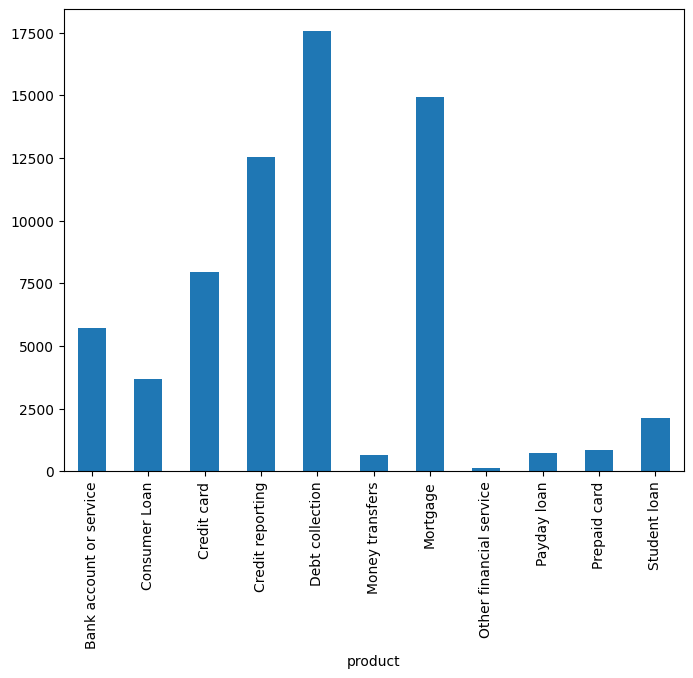

In [11]:
fig = plt.figure(figsize=(8, 6))
product_quantity.plot.bar(ylim=0)

### Data splitting


In [12]:
from sklearn.model_selection import train_test_split
from sklearn import (
    model_selection,
    preprocessing,
    linear_model,
    naive_bayes,
    metrics,
    svm,
)

In [13]:
train_x, valid_x, train_y, valid_y = train_test_split(
    df["consumer_complaint_narrative"], df["product"], random_state=42
)

In [14]:
label_encoder = preprocessing.LabelEncoder()

train_y = label_encoder.fit_transform(train_y)
valid_y = label_encoder.transform(valid_y)

### Feature extraction using TF-IDF


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [16]:
tf_idf_vect = TfidfVectorizer(
    analyzer="word",
    token_pattern=r"\w{1,}",  # split câu thành các từ
    max_features=5000,
)

In [ ]:
tf_idf_vect.fit(df["consumer_complaint_narrative"])

xtrain_tf_idf = tf_idf_vect.transform(train_x)
xvalid_tf_idf = tf_idf_vect.transform(valid_x)

### Build model and evaluate performance


In [18]:
model = linear_model.LogisticRegression(
    C=1.0,
    class_weight=None,
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    max_iter=100,
    multi_class="ovr",
    n_jobs=1,
    penalty="l2",
    random_state=None,
    solver="liblinear",
    tol=0.0001,
    verbose=0,
    warm_start=False,
).fit(xtrain_tf_idf, train_y)

d:\School\4thYear\2ndSemester\NLP\Labs\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [19]:
model

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [20]:
accuracy = metrics.accuracy_score(model.predict(xvalid_tf_idf), valid_y)

In [21]:
accuracy

0.8455873548078074

In [22]:
# Classification report
print(
    metrics.classification_report(
        valid_y, model.predict(xvalid_tf_idf), target_names=df["product"].unique()
    )
)

                         precision    recall  f1-score   support

        Debt collection       0.81      0.79      0.80      1454
          Consumer Loan       0.82      0.60      0.69       912
               Mortgage       0.82      0.80      0.81      2039
            Credit card       0.85      0.85      0.85      3110
       Credit reporting       0.81      0.90      0.85      4377
           Student loan       0.85      0.47      0.60       180
Bank account or service       0.92      0.96      0.94      3687
            Payday loan       0.00      0.00      0.00        26
        Money transfers       0.61      0.15      0.23       193
Other financial service       0.78      0.57      0.66       202
           Prepaid card       0.88      0.80      0.84       522

               accuracy                           0.85     16702
              macro avg       0.74      0.63      0.66     16702
           weighted avg       0.84      0.85      0.84     16702



d:\School\4thYear\2ndSemester\NLP\Labs\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\School\4thYear\2ndSemester\NLP\Labs\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\School\4thYear\2ndSemester\NLP\Labs\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [23]:
from sklearn.metrics import confusion_matrix

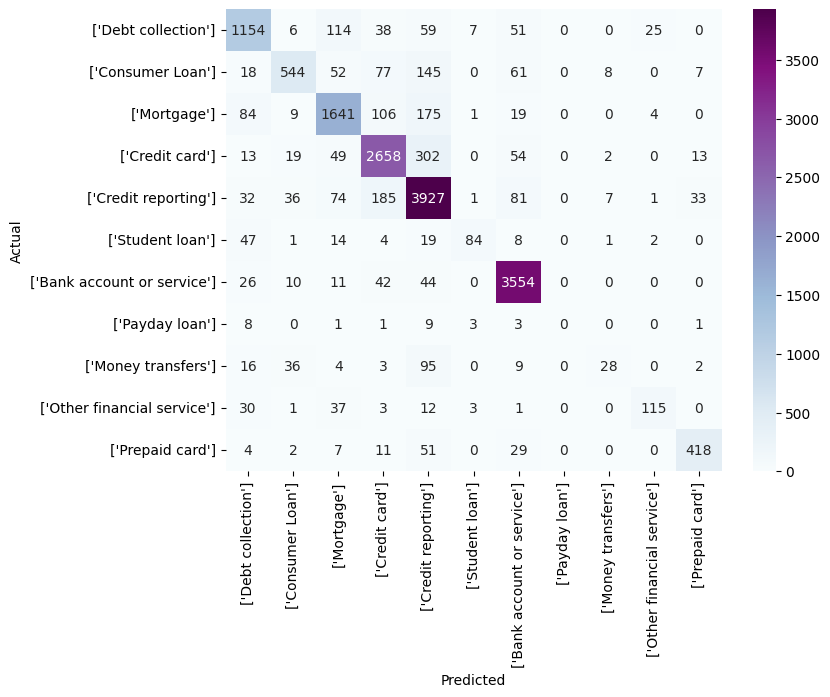

In [24]:
# confusion matrix
conf_mat = confusion_matrix(valid_y, model.predict(xvalid_tf_idf))
# Vizualizing confusion matrix
category_id_df = (
    df[["product", "category_id"]].drop_duplicates().sort_values("category_id")
)
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[["category_id", "product"]].values)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="BuPu",
    xticklabels=category_id_df[["product"]].values,
    yticklabels=category_id_df[["product"]].values,
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

Evaluation:
- Overall accuracy is 84.5%, quite good
- But the model is not very good at predicting the minority class (such as Payday loans) which has f1-score of 0

### Testing


In [25]:
texts = [
    "This company refuses to provide me verification and validation of debt"
    + "per my right under the FDCPA. I do not believe this debt is mine."
]
text_features = tf_idf_vect.transform(texts)
predictions = model.predict(text_features)
print(texts)
print("  - Predicted as: '{}'".format(id_to_category[predictions[0]]))

['This company refuses to provide me verification and validation of debtper my right under the FDCPA. I do not believe this debt is mine.']
  - Predicted as: 'Credit reporting'


### Try to improve the model performance

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
model = RandomForestClassifier(
    n_estimators=100,       # Số lượng cây trong rừng (thường bắt đầu từ 100–200)
    max_depth=None,         # Để None cho đến khi cần tuning
    random_state=42,        # Đảm bảo tái lập kết quả
    n_jobs=-1,              # Dùng hết CPU để train nhanh hơn
)

model.fit(xtrain_tf_idf, train_y)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [30]:
accuracy = metrics.accuracy_score(model.predict(xvalid_tf_idf), valid_y)

print("Accuracy: ", accuracy)

Accuracy:  0.8100826248353491
